In [1]:
from Deproject_v1 import *
from Deproject_test import *
from scipy import sparse as scisp
import sparse as sp
import cProfile
plt.style.use('classic')

## Deprojection of velocities for solar vicinity stars

The purpose of the code is to infer the velocity distribution $f(\boldsymbol{v})$ of solar neighbourhood stars through numerical maximization of the following function from [(Dehnen, 1998)](https://ui.adsabs.harvard.edu/#abs/1998AJ....115.2384D/abstract) (henceforth D98):

\begin{equation}
\tilde{\mathcal{L}}_\alpha (\phi) = N^{-1} \sum_k \ln \left[ \sum_\boldsymbol{\ell} e^{\phi_\boldsymbol{\ell}} K(k\ |\ \boldsymbol{\ell}) \right] - \sum_\boldsymbol{l} e^{\phi_\boldsymbol{\ell}} - \frac{1}{2}\alpha h_x h_y h_z \sum_\boldsymbol{\ell} \left( \sum_\boldsymbol{n} \phi_\boldsymbol{n} \Xi_\boldsymbol{n\ell} \right).
\end{equation}

Each term is computed using different sections in the code, which then are combined in the function $\texttt{get_negL}$. Said function is then maximized using the conjugate gradient algorithm.

We begin by initiating our data. This can be done by either reading data from a file or by creating a pseudosample of stars with a given Gaussian velocity dispersion. The latter can be used to test the program and to see that the maximization scheme is working as intended.

The data is transformed to a right-handed Galactic (l,b) frame of reference with Cartesian representation using the $\texttt{astropy}$ library.

In [2]:
#Initiation of data, now loading GRD1 data and setting up the various parameters used in the code below

try:
    data_raw
except NameError:
    
    data_raw = ascii.read('Distances_PJM2017.csv', format='fast_csv')
    
RA = data_raw['RAdeg']*u.degree
DEC = data_raw['DEdeg']*u.degree
pm_RA = data_raw['pmRA_TGAS']*u.mas/u.yr
pm_DEC = data_raw['pmDE_TGAS']*u.mas/u.yr
parallax = data_raw['parallax']*u.mas

dist = parallax.to(u.kpc,equivalencies=u.parallax())

near_stars = np.where(dist.value<0.1)

sample_raw = coord.ICRS(ra = RA, dec = DEC, pm_ra_cosdec = pm_RA, pm_dec = pm_DEC,distance=dist)

sample = sample_raw[near_stars]

sample = sample.transform_to(coord.Galactic)

If we choose to use pseudodata instead, we can specify the desired number of stars, $N$, as well as the mean velocities and dispersions for the Gaussian velocity distribution of each component $v_x,\ v_y,\ v_z$. The pseudosample can then be generated using the $\texttt{model_sample}$ function.

In [27]:
N = 3000 #Number of stars we want to use in our sample
v0 = np.array([0,0,0]) #The mean velocities of our pseudosample Gaussian velocity distributions
v_disp = np.array([50,50,50]) #The velocity dispersions of the Gaussians
sample = model_sample(N,v0,v_disp) #Uncomment to use pseudosample

Essentially, we project the possible values of the radial velocity for each specimen $k$ in a set of $N$ stars onto our $v$-space in order to get an estimate of the underlying probability distribution function.

The method of projection has been adopted from [(Dehnen & Binney, 1998)](https://ui.adsabs.harvard.edu/#abs/1998MNRAS.298..387D/abstract) (henceforth DB98). First, we compute the proper motion velocity $p_k$ for a star $k$ and project the possible values of its radial velocity by drawing a line through the point $p_k$ in $v$-space. The line has the same direction as the unit vector of the star $\boldsymbol{\hat{r}}$ solves $\boldsymbol{v} = \boldsymbol{p}_k + v_r \boldsymbol{\hat{r}}$.

The proper motion velocity is given by the following equation:

\begin{equation}
\boldsymbol{p} = \frac{1\ \mathrm{au}}{\sin\pi} \begin{bmatrix} -\sin l \cos b \mu_l-\cos l \sin b \mu_b \\ \cos l \cos b \mu_l-\sin l \sin b \mu_b \\ \cos b \mu_b \end{bmatrix}, 
\end{equation}

where $\mu_l = \mu_l^{\mathrm{obs}} - A\cos(2l)-B$ and $\mu_b = \mu_b^{\mathrm{obs}} + A\sin(2l)\cos b \sin b$ and $\pi$ is the star's parallax. We correct the observed proper motions, using the Oort constant values from [(Bovy, 2018)](https://ui.adsabs.harvard.edu/#abs/2017MNRAS.468L..63B/abstract).

Furthermore, the unit vector for each star can be calculated from

\begin{equation}
\boldsymbol{\hat{r}} = \begin{pmatrix} \cos b \cos l \\ -\sin l \\ -\sin b \cos l  \end{pmatrix}.
\end{equation}



In [28]:
#Oort constant values from Bovy (2018)
A = (15.3*(u.km/(u.s*u.kpc))).to(1/u.yr)
B = (-11.9*(u.km/(u.s*u.kpc))).to(1/u.yr)

bvals = sample.b.to(u.deg)
lvals = sample.l.to(u.deg)

mul_obs = sample.pm_l.to(1/u.yr,equivalencies = u.dimensionless_angles())
mub_obs = sample.pm_b.to(1/u.yr,equivalencies = u.dimensionless_angles())

"""Computation of the relevant quantities

    l,b: Galactic coordinates
    s: the distance obtained by inverting the parallax
    mul, mub: proper motion in l and b
    pvals: Tangential velocities obtained from eq. 2 in DB98
    rhatvals: The unit vector of each star
    vmin: Vector containing the minimum velocities in v-space
    n: The number of cells we want in each dimension of our v-space box
    dv: Step sizes for each dimension"""

b = np.deg2rad(bvals).value # just a test
l = np.deg2rad(lvals).value
cosl = np.cos(l)
cosb = np.cos(b)
sinl = np.sin(l)
sinb = np.sin(b)
s = sample.distance

mul = mul_obs - A*np.cos(2*l)-B
mub = mub_obs + A*np.sin(2*l)*cosb*sinb

pvals = s*np.array([-sinl*cosb*mul - cosl*sinb*mub,
                 cosl*cosb*mul - sinl*sinb*mub,
                 cosb*mub])/u.yr
    
rhatvals = np.array([cosb*cosl, cosb*sinl, sinb]).T
pvals = pvals.to(u.km/u.s).value.T

Our method of inferring the velocity distribution $f(\boldsymbol{v})$ is based on the assumption that the velocity distribution must be positive. Hence we can define $f(\boldsymbol{v}) = e^{\phi(\boldsymbol{v})}$. 

We thus look to find $\phi(\boldsymbol{v})$, which can be done by creating a box of lengths $n = n_x\times n_y\times n_z$ of sides $d_{vx},\ d_{vy},\ d_{vz}$. We also have to specify the anchor of our box by defining $v_{min}$.

Hence we get a box that covers the ranges $v_i \in [v_{i,min},v_{i,min}+n_i d_{vi}]$, where $i = x,y,z$ with cells that have positions given by the three dimensional vector $\boldsymbol{\ell} = (\ell_x,\ell_y,\ell_z)$.

In [29]:
#For example we can choose

n = np.array([8,8,8])
dv = np.array([50,50,50])
vmin = np.array([-200,-200,-200])

### The first term of $\tilde{\mathcal L}$

In order to $f(\boldsymbol{v})$ we are first interested in finding the probability of observing the tangential velocity $\boldsymbol{p}_k$ for a star in direction $\boldsymbol{\hat{r}}$ with velocity drawn from $f(\boldsymbol{v})$. This probability is given by

\begin{equation}
P(\boldsymbol{q}_k\ |\ \boldsymbol{\hat{r}}_k,f) = \int \mathrm{d} v_r f(\boldsymbol{v} = \boldsymbol{p}_k +v_r \boldsymbol{\hat{r}}),
\end{equation}

where $\boldsymbol{q}_k = (v_{l,k},v_{b,k})$

This equation can be numerically approximated from the following equation

\begin{equation}
P(\boldsymbol{q}_k\ |\ \boldsymbol{\hat{r}}_k,f) = \sum_\boldsymbol{\ell} e^{\phi_\boldsymbol{\ell}} K(k\ |\ \boldsymbol{\ell}).
\end{equation}

$K(k\ |\ \boldsymbol{\ell})$ can be computed by multiplying $(d_{vx}d_{vy}d_{vz})^{-1}$ times the length in $v_r$ of the line $\boldsymbol{v} = \boldsymbol{p}_k + v_r\boldsymbol{\hat{r}}$ in each cell $\boldsymbol{\ell}$. Hence the first term in the expression for $\tilde{\mathcal{L}}$ can be recognised as the log-likelihood of a velcocity distribution $f(\boldsymbol{v})$.

In the Deprojection code, the computation of $K(k\ |\ \boldsymbol{\ell})$ is performed by the function $\texttt{calc_K}$. Given a $\boldsymbol{v}$-space and a star $k$, it solves the line equation $\boldsymbol{v} = \boldsymbol{p}_k + v_r\boldsymbol{\hat{r}}$ for $v_r$ in every dimension by looking at the lines intersections with the cell edges. The rest of the code runs as follows:

1. We obtain three sets of $v_r$ values, one for each dimension
2. We then combine values from these three sets by requiring that all values of $v_r$ must be smaller than the smallest maximum value of our three sets and vice versa for the lower boundary.
3. The new set of values is then sorted and used to obtain the value of $v_r$ in the centre of each box $\boldsymbol{\ell}$
4. The centre values of $v_r$ are used to once more solve our line equation to get the corresponding points in $\boldsymbol{v}$-space $\boldsymbol{v'}=(v_x',v_y',v_z')$
5. We compute the corresponding index $\boldsymbol{\ell}$ of the cell with $(\boldsymbol{v'}-\boldsymbol{v_{min}})/d_{v}$
6. The length of the line in each segment is evaluated
7. Said length is multiplied by $(d_{vx}d_{vy}d_{vz})^{-1}$ to obtain $K(k\ |\ \boldsymbol{\ell})$ for each cell

In order to visualize this we use the $\texttt{plot_K}$ function found in $\texttt{Deproject_test.py}$ for the pseduosample previously created. This function computes $\sum_k K(k\ |\ \boldsymbol{\ell})$, yielding an $n$-dimensional array with values that is then projected onto a plane of choice.

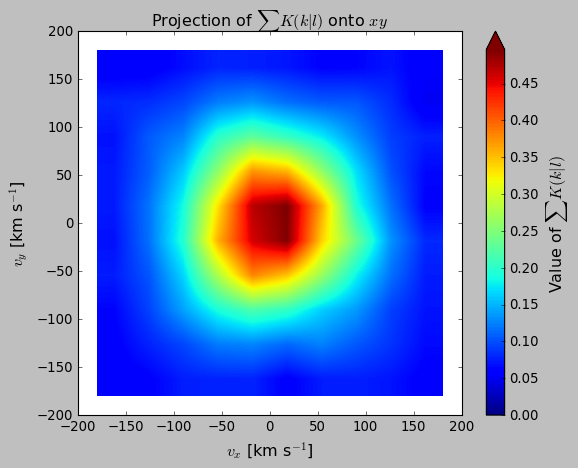

In [8]:
from Deproject_plots import plot_K

plot_K('xy', pvals, rhatvals, vmin, dv, n)

Given our initial Gaussian velocity distribution for our set of pseudo-stars, we would expect to find that the probability of finding a star with a given tangential velocity $\boldsymbol{p}_k$ is largest in the centre of our box, which is what we would expect.

### The third term of $\tilde{\mathcal L}$

The first function required to calculate the final term of $\tilde{\mathcal L}$ is $\texttt{calc_sigma2}$. This function employs the linear algebra required to obtain the the velocity dispersion tensor $\boldsymbol{\sigma}^2$ for a given set of stars, as described in sections 3.2 and 3.3 in DB98. The final equation that yields $\boldsymbol{\sigma}^2$ is

\begin{equation}
\begin{pmatrix} \sigma_x^2 \\ \sigma_y^2 \\ \sigma_z^2 \end{pmatrix} = \frac{3}{14} \begin{pmatrix} 9 & -1 & -1 \\ -1 & 9 & -1 \\ -1 & -1 & 9 \end{pmatrix}\cdot \begin{pmatrix} \langle p_x' p_x' \rangle \\ \langle p_y' p_y' \rangle \\ \langle p_z' p_z' \rangle \end{pmatrix},
\end{equation}

where $p_i'$ is the tangential velocity of a star relative to the sample mean tangential velocity $\langle p_i \rangle$ for $i = x,y,z$.

With the value of $\boldsymbol{\sigma}^2$ at hand, we are fit to investigate the sum $\sum_\boldsymbol{n} \phi_\boldsymbol{n} \Xi_{\boldsymbol{n\ell}}$. This expression is a numerical approximation of $\nabla^2 \ln f(\boldsymbol{v_\boldsymbol{\ell}})$, which integrated over $\boldsymbol{v}$-space describes the roughness of $f(\boldsymbol{v})$. 

In the estimation of the second derivative of $\tilde{\mathcal L}$ in each cell $\boldsymbol{\ell}$ we have to consider the contributions from the adjacent cells. Therefore, we get the following expression for $\Xi_{\boldsymbol{n\ell}}$.

\begin{equation}
\Xi_{\boldsymbol{n\ell}} = \sum_{i=x,y,z} \frac{\sigma^2_i}{d_{vi}} (-2\delta_{\boldsymbol{n},\boldsymbol{\ell}} + \delta_{\boldsymbol{n},\boldsymbol{\ell+\hat{e}_i}} + \delta_{\boldsymbol{n},\boldsymbol{\ell-\hat{e}_i}}),
\end{equation}

where $\hat{e}_i$ is the unit vector in dimension $i$. Given the Kronecker-Delta functions of the equation, we will get a maximum number of seven contributions for each cell. A cell will have fewer contributions if it lies by one of the box edges. For example, a corner cell at $\boldsymbol{\ell} = (0,0,0)$ will only have three adjacent cells and thereby four contributions to $\Xi_{\boldsymbol{n\ell}}$.

In order to solve this numerically, we opted to place our $\boldsymbol{v}$-space box in the centre of a slightly larger box of size $n'= n_x'\times n_y' \times n_z'$, where $n_i' = n_i +2$. This yields an extra plane of cells at each of the box sides where $\phi_\boldsymbol{\ell}=0$. This allowed us to bypass the need for loops and instead use simple addition of arrays to separately sum the contributions from the adjacent cells in each dimension. 

#### The smoothing parameter $\alpha$

...(To be added)

### Initial guess of $\boldsymbol{\phi}$

Furthermore we need to provide an initial guess of the vector $\boldsymbol{\phi}=(\phi_{\boldsymbol{\ell}=(0,0,0)},...)$, which contains the variables that are free in our maximization. Since the distribution for of velocities for a real sample of stars will be complex and difficult to guess, we opt to base our first input on the sum of three Gaussians. This is done by the function $\texttt{phi_guess}$, which given values for the mean velocities $\mu$ and the velocity dispersion $\sigma$ for the Gaussian guess of each dimension $x,\ y,\ z$, as well as the variables determining the dimensions of our box, will return a three-dimensional array containing all the corresponding values of $\phi$ for our guess.

It does so in the following manner:
1. We set up our box given $n,\ d_v,\ v_{min}$ 
2. The velocities corresponding to the centre of each box is determined
3. We calculate the normal distribution given the initial $\mu$ and $\sigma$
4. The probability of our cell velocity values being in said normal distribution is determined 

In [17]:
v_guess = np.array([2,1,-3])
disp_guess = np.array([30,30,30])

mxl, phiall = max_L(8e-14, pvals, rhatvals, vmin, dv, n)
# cProfile.run('max_L(8e-14, pvals, rhatvals, vmin, dv, n,v0_guess=v_guess, disp_guess=disp_guess)')

# sanity_check(pvals,rhatvals,mxl,vmin,dv,n)

Optimization terminated successfully.
         Current function value: 11.631190
         Iterations: 77
         Function evaluations: 319
         Gradient evaluations: 319


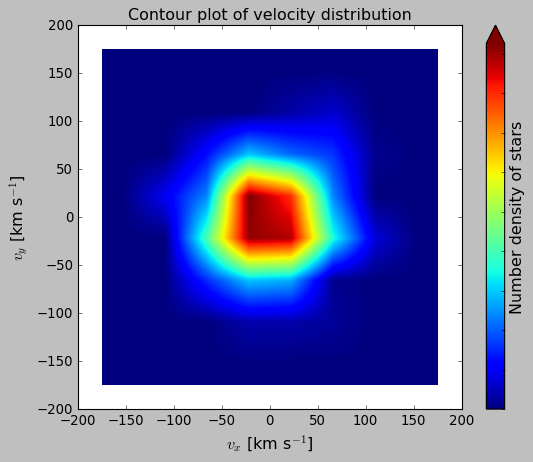

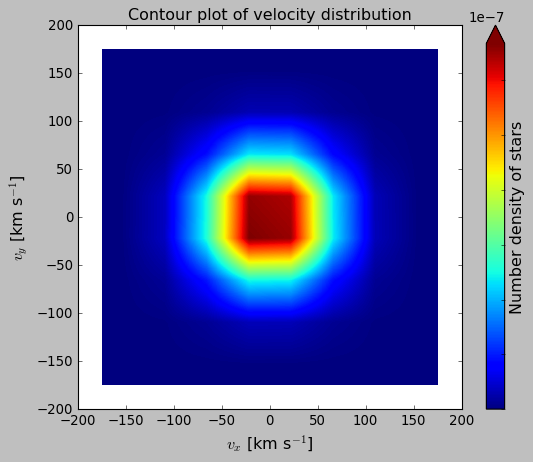

In [18]:
from Deproject_plots import plot_fv

plot_fv(mxl,'xy',vmin,dv,n)

sigma2, vmean0 = calc_sigma2(pvals,rhatvals,True)

sigma = np.sqrt(sigma2)

phi0 = phi_guess(vmean0,sigma,vmin,dv,n)

plot_fv(phi0,'xy',vmin,dv,n)

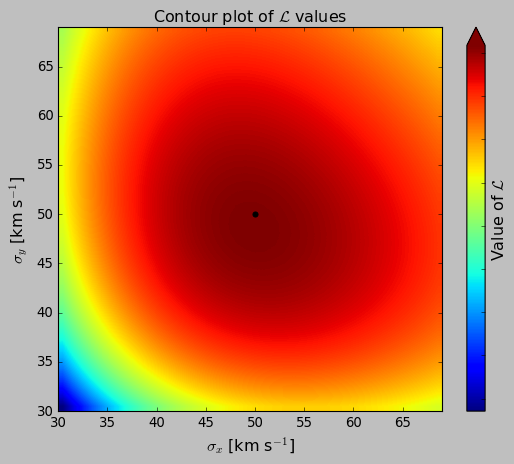

In [6]:
test_L('xy', 8e-14, v0, v_disp, pvals, rhatvals, vmin, dv, n)

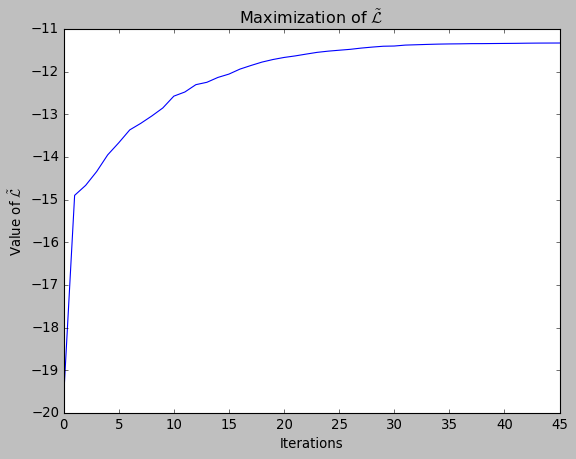

In [11]:
from Deproject_plots import plot_L

plot_L(phiall,pvals,rhatvals,vmin,dv,n,1e-15)

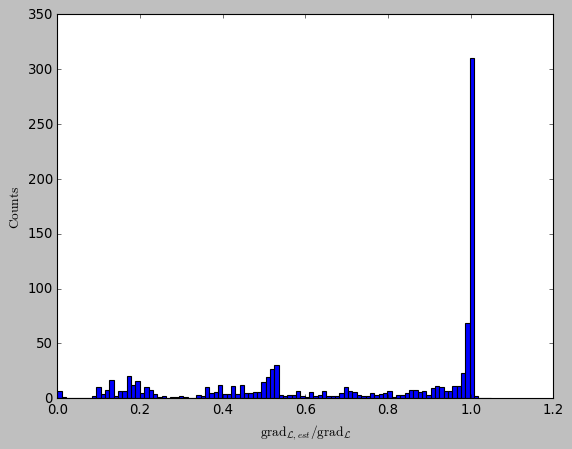

In [19]:
from Deproject_test import grad_negL_test

testvals, twon = grad_negL_test(phi0,pvals,rhatvals,1e-13,vmin,dv,n)

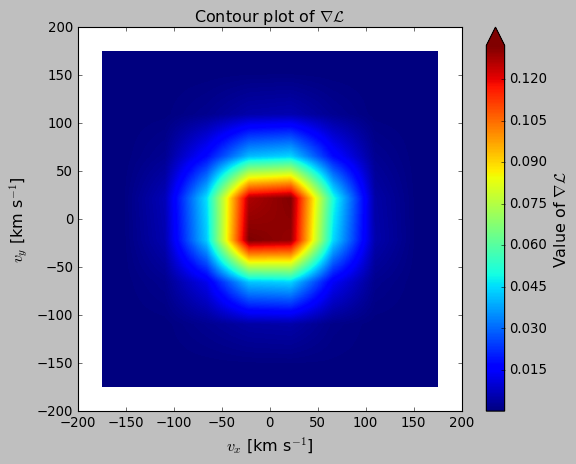

In [47]:
plot_grad_L(phi0,'xy',1e-15,pvals,rhatvals,vmin, dv,n)

In [21]:
def opt_alpha(alpha0,M,N,pvals,rhatvals,vmin,dv,n,tol=0.01):
    
    import time
    
    start_time = time.time()
    
    diff = 1
    s = 0

    logalpha0 = np.log10(alpha0)
    logalphavals = np.linspace(logalpha0-5,logalpha0+5,10) #logarithm

    vxmin, vymin, vzmin = vmin
    dvx, dvy, dvz = dv
    nx, ny, nz = n

    vxmax, vymax, vzmax = vxmin+nx*dvx,vymin+ny*dvy,vzmin+nz*dvz

    vx_bins = np.arange(vxmin, vxmax+dvx, dvx)
    vy_bins = np.arange(vymin, vymax+dvy, dvy)
    vz_bins = np.arange(vzmin, vzmax+dvz, dvz)

    vxc = (vx_bins[1:]+vx_bins[:-1])/2
    vyc = (vy_bins[1:]+vy_bins[:-1])/2
    vzc = (vz_bins[1:]+vz_bins[:-1])/2

    vxx, vyy, vzz = np.meshgrid(vxc,vyc,vzc,indexing='ij')

    ind = np.indices((nx,ny,nz))

    rind = np.ravel_multi_index(ind,(nx,ny,nz))

    rrind = np.ravel(rind)

    while diff>=tol:

        phi0, phiall = max_L(alpha0, pvals, rhatvals, vmin, dv, n, disp=0)

        fv0 = np.exp(phi0)
        fv0s = np.sum(fv0)
        prob = np.ravel(fv0/fv0s)

        smp = np.random.choice(rrind,(M,N),p=prob)

        smpx, smpy, smpz = np.asarray(np.unravel_index(smp,(nx,ny,nz)))

        vxvals = vxx[smpx,smpy,smpz].T
        vyvals = vyy[smpx,smpy,smpz].T
        vzvals = vzz[smpx,smpy,smpz].T

        smpvals = np.asarray([vxvals, vyvals, vzvals]).T

        ise = np.zeros((M,len(logalphavals)))

        for i in range(M):

            for j in range(len(logalphavals)):

                alpha = 10**(logalphavals[j])

                phi, phiall = max_L(alpha, smpvals[i], rhatvals, vmin, dv, n, disp=0)

                fv = np.exp(phi)

                ise[i][j] = np.sum((fv-fv0)**2)

        mise = np.mean(ise,axis=0)

        minmise = np.amin(mise)

        optind = np.argwhere(mise==minmise)[0][0]

        logalpha_opt = logalphavals[optind]

        diff = abs(logalpha0 - logalpha_opt)

        logalpha0 = logalpha_opt

        if optind == 0:
            lower = logalpha0-2
            upper = logalphavals[optind+1]
        elif optind == (len(logalphavals)-1):
            lower = logalphavals[optind-1]
            upper = logalpha0+2
        else:
            lower = logalphavals[optind-1]
            upper = logalphavals[optind+1]

        logalphavals = np.linspace(lower,upper,10)

        s+=1
        
        print(s)

    alpha_fin = 10**(logalpha0)    

    print("The run took", time.time() - start_time, 's')
    print('It took',s,'iterations')
    print('The optimal value for alpha is',alpha_fin)
    
    return

In [31]:
alpha0, M, N = 1e-12, 10, 3000

#opt_alpha(alpha0,M,N,pvals,rhatvals,vmin,dv,n)

In [119]:
import cProfile

dvx, dvy, dvz = dv
nx, ny, nz = n
    
N = len(pvals)

sigma2, vmean = calc_sigma2(pvals,rhatvals, give_vmean=True)

sigma = np.sqrt(sigma2)

phi0 = phi_guess(vmean,sigma,vmin,dv,n) #We obtain phi given our initial guess of the velocity distribution

Kvals = np.zeros((N,nx,ny,nz))

for i in range(N):
    K = calc_K(pvals[i],rhatvals[i],vmin,dv,n)
    Kvals[i] += K   

phi0 = np.ravel(phi0) #fmin_cg only takes one-dimensional inputs for the initial guess


#%timeit get_negL(phi0, Kvals, N, 8e-14, dv, n, sigma2)

# cProfile.run('get_negL(phi0, Kvals, N, 8e-14, dv, n, sigma2)')

%timeit get_grad_negL(phi0, Kvals, N, 8e-14, dv, n, sigma2)
# old = get_grad_negLL(phi0, Kvals, N, 8e-14, dv, n, sigma2)

1.44 s ± 34.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
